#Preamble & Imports

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'playground-series-s4e4:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F72489%2F8096274%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240514%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240514T205200Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D422b97be56f6585ad8a95ed8c27b6b589ec5eae1bca202e4657497257b92ca97607185de1dcc412015f4cc51f56801f1339d67573841a3824148bf771ab3cf6fa860bb8bbc9de620af55746fd54bd36c44d1b102d5d7f3654f379f7be1c2ed54d426a7a6db45125c2db4f7b2999a768c22a3275500be7e20f45812e1f8ec2d346be051a7b817ff4261749ff9a385e5ef70a95a8b467d50d07e2e177f01a79503b92046443513bc8584f23b787033091ca6c87ac97e0b81e23e700916043879630f2fe0fd8c1ea194ac30b3c98483dd856e2f0be0db83a27024530f88e8416992a1a04f04b66acac069efda5ed713a50c43c0e1aa3a83870427660b21b3ed1a10'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2529839 bytes downloaded
Downloaded and uncompressed: playground-series-s4e4
Data source import complete.


In [3]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 2.7 MB/s eta 0:00:00


In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, VotingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import joblib
import warnings

# Suppress specific FutureWarnings from sklearn ensemble
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.ensemble._forest")


#Data Loading

In [5]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

# fetch dataset
abalone = fetch_ucirepo(id=1)

# data (as pandas dataframes)
X_uci = abalone.data.features
y_uci = abalone.data.targets


In [6]:
def load_data():
    train_data = pd.read_csv('/kaggle/input/playground-series-s4e4/train.csv')
    test_data = pd.read_csv('/kaggle/input/playground-series-s4e4/test.csv')
    return train_data, test_data

# Usage
train_data, test_data = load_data()

#Data Exploration

In [12]:

# Load your dataset
# Assuming your data is in a DataFrame called `train_data`
# train_data = pd.read_csv('your_dataset.csv')

# Display the first few rows of the dataset
print("First few rows of the dataset:")
print(train_data.head())

# Display the summary statistics of the dataset
print("\nSummary statistics of the dataset:")
print(train_data.describe())

# Check for missing values
print("\nMissing values in each column:")
print(train_data.isnull().sum())

# Display data types of each column
print("\nData types of each column:")
print(train_data.dtypes)

First few rows of the dataset:
   id Sex  Length  Diameter  Height  Whole weight  Whole weight.1  \
0   0   F   0.550     0.430   0.150        0.7715          0.3285   
1   1   F   0.630     0.490   0.145        1.1300          0.4580   
2   2   I   0.160     0.110   0.025        0.0210          0.0055   
3   3   M   0.595     0.475   0.150        0.9145          0.3755   
4   4   I   0.555     0.425   0.130        0.7820          0.3695   

   Whole weight.2  Shell weight  Rings  
0          0.1465        0.2400     11  
1          0.2765        0.3200     11  
2          0.0030        0.0050      6  
3          0.2055        0.2500     10  
4          0.1600        0.1975      9  

Summary statistics of the dataset:
                 id        Length      Diameter        Height  Whole weight  \
count  90615.000000  90615.000000  90615.000000  90615.000000  90615.000000   
mean   45307.000000      0.517098      0.401679      0.135464      0.789035   
std    26158.441658      0.118217  

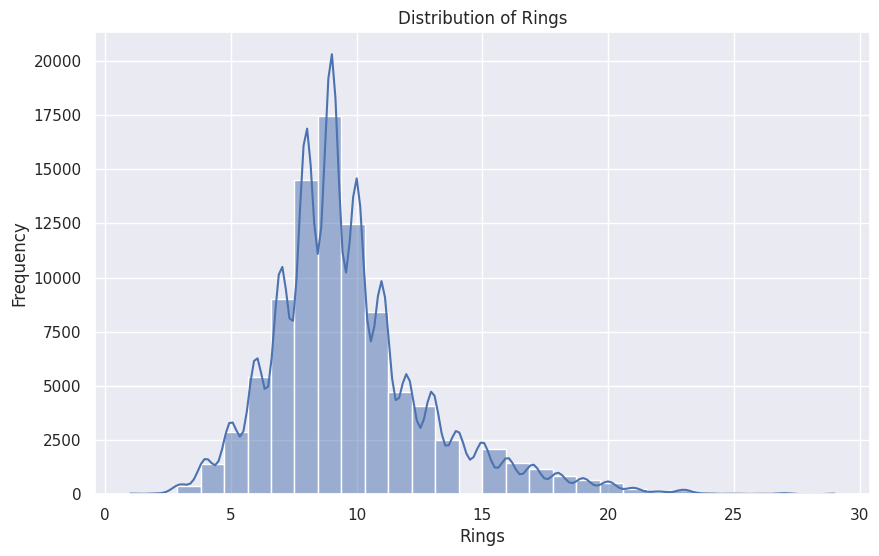

In [8]:

# Distribution of target variable 'Rings'
plt.figure(figsize=(10, 6))
sns.histplot(train_data['Rings'], bins=30, kde=True)
plt.title('Distribution of Rings')
plt.xlabel('Rings')
plt.ylabel('Frequency')
plt.show()

The histogram shows the distribution of the target variable 'Rings', indicating a right-skewed distribution with the majority of values centered around 9-10 rings.

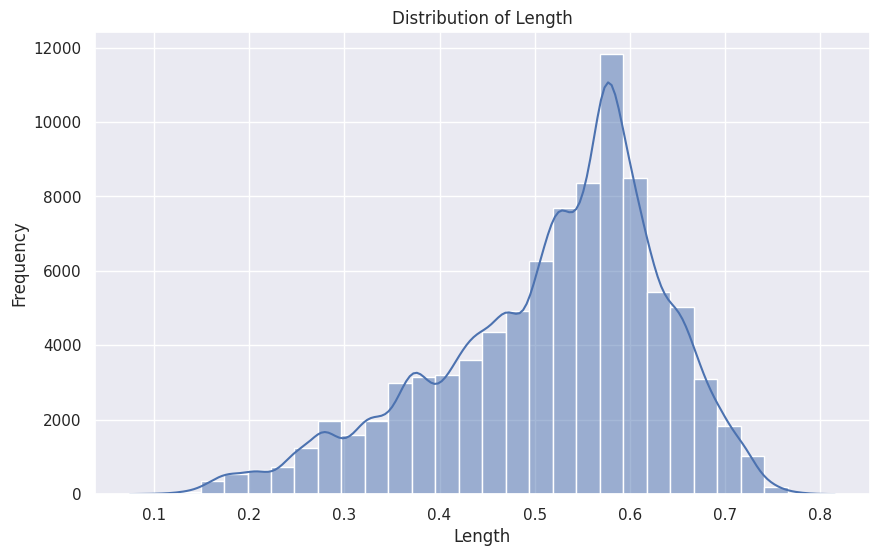

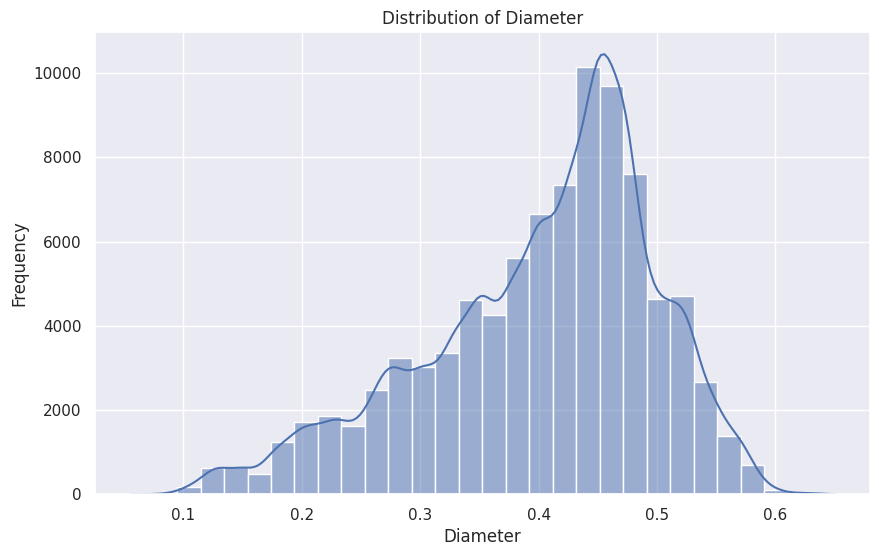

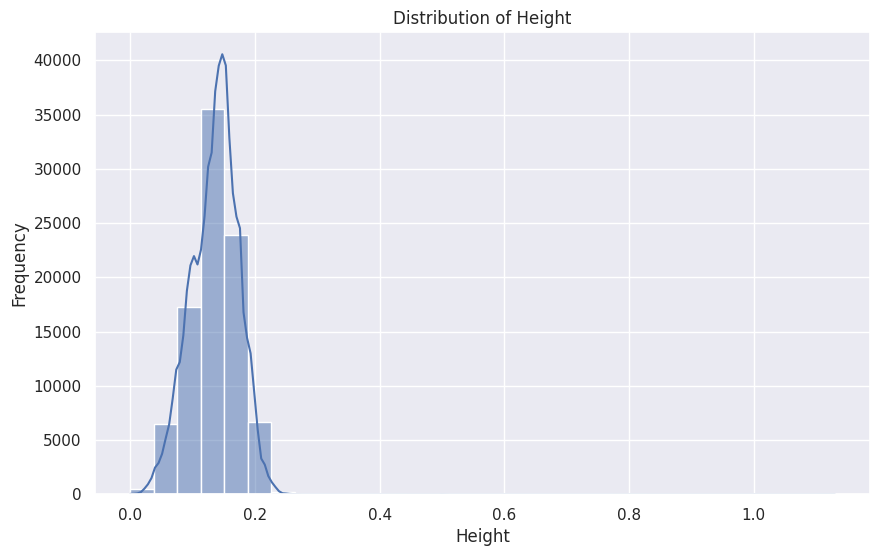

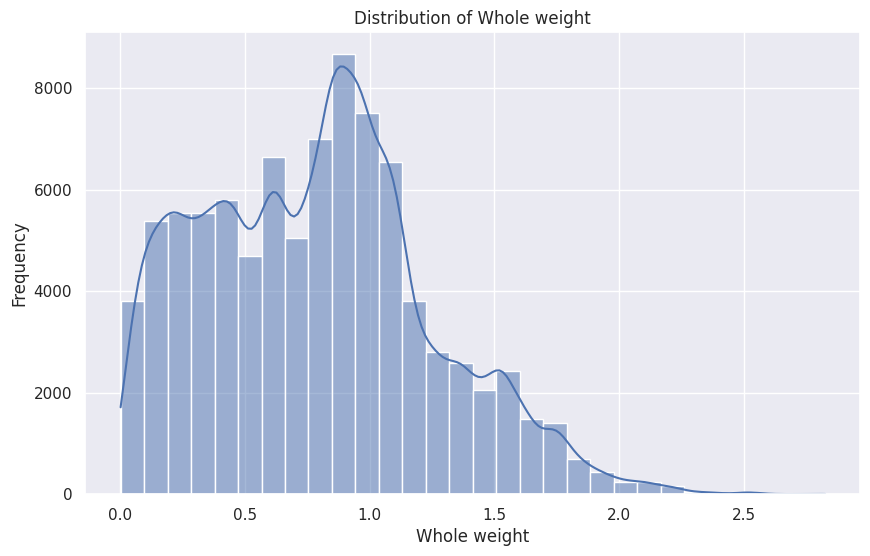

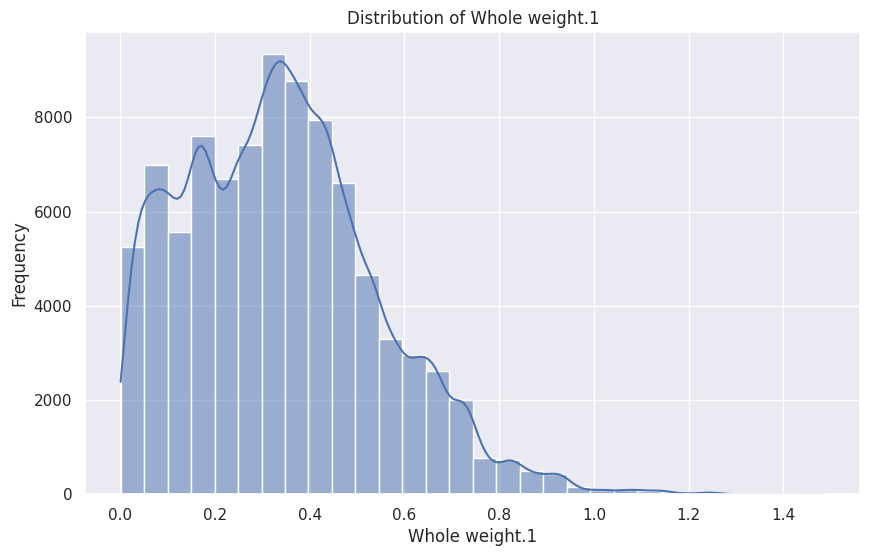

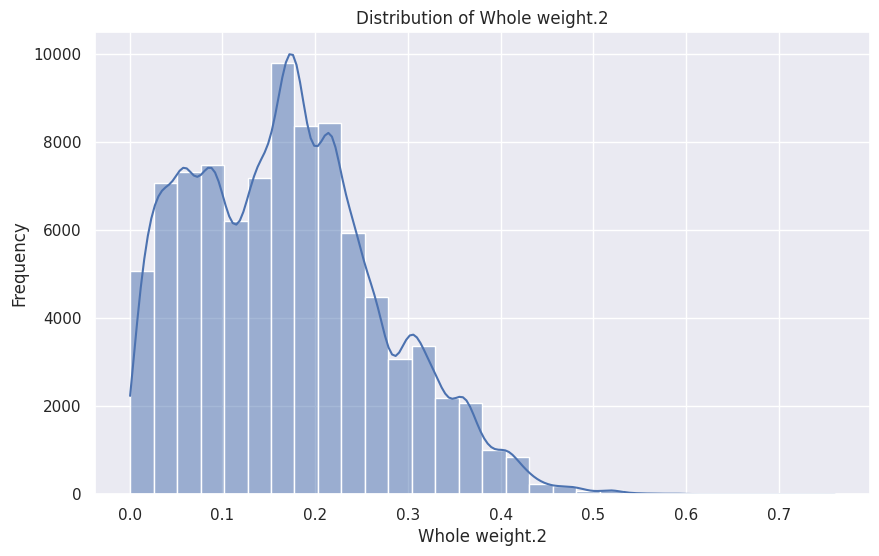

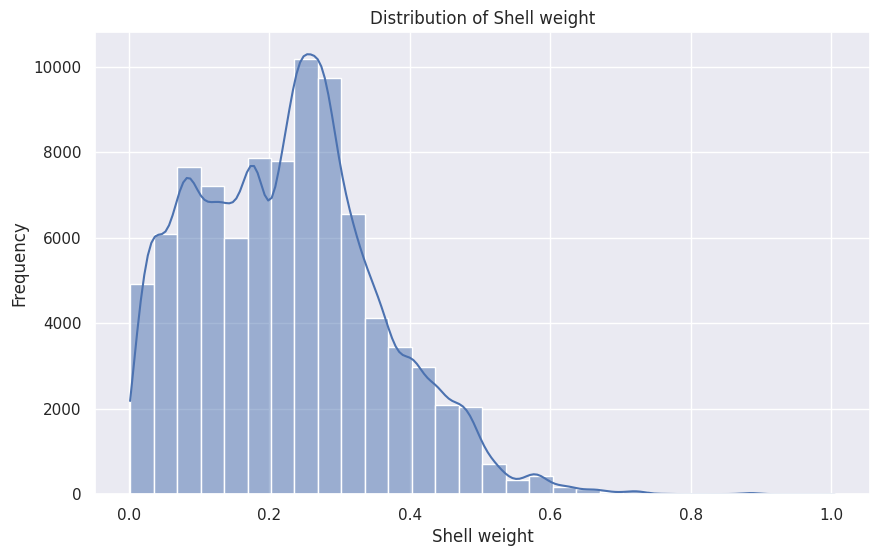

In [9]:

# Distribution of numerical features
numerical_features = ['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(train_data[feature], bins=30, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()


Correlation matrix:
                  Length  Diameter    Height  Whole weight  Whole weight.1  \
Length          1.000000  0.989732  0.916094      0.931449        0.909609   
Diameter        0.989732  1.000000  0.919618      0.933848        0.908466   
Height          0.916094  0.919618  1.000000      0.902344        0.861769   
Whole weight    0.931449  0.933848  0.902344      1.000000        0.971249   
Whole weight.1  0.909609  0.908466  0.861769      0.971249        1.000000   
Whole weight.2  0.913134  0.914668  0.886132      0.974319        0.949227   
Shell weight    0.911073  0.917871  0.904019      0.964201        0.911800   
Rings           0.623786  0.636832  0.665772      0.617274        0.515067   

                Whole weight.2  Shell weight     Rings  
Length                0.913134      0.911073  0.623786  
Diameter              0.914668      0.917871  0.636832  
Height                0.886132      0.904019  0.665772  
Whole weight          0.974319      0.964201  0.

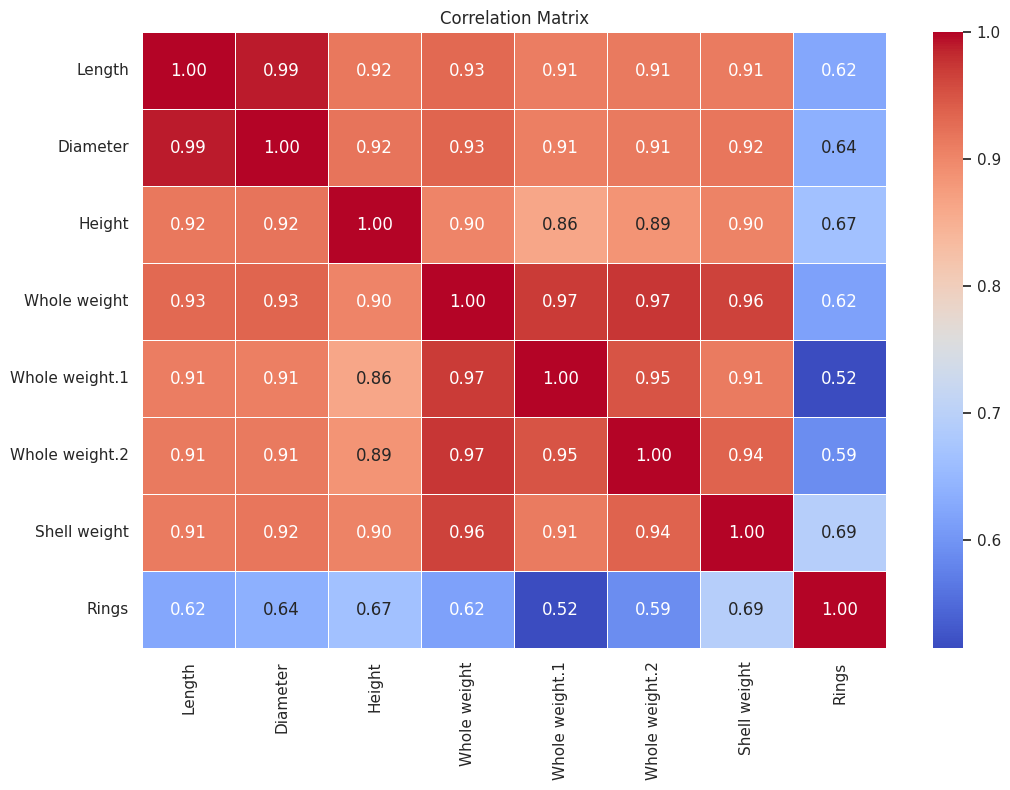

In [10]:

# Correlation matrix
# Filter the DataFrame to include only numerical columns
numerical_data = train_data[numerical_features + ['Rings']]
corr_matrix = numerical_data.corr()
print("\nCorrelation matrix:")
print(corr_matrix)

# Visualizing the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

The correlation matrix visualizes the relationships between different numerical features, indicating that 'Shell weight' has the highest positive correlation with the target variable 'Rings'.

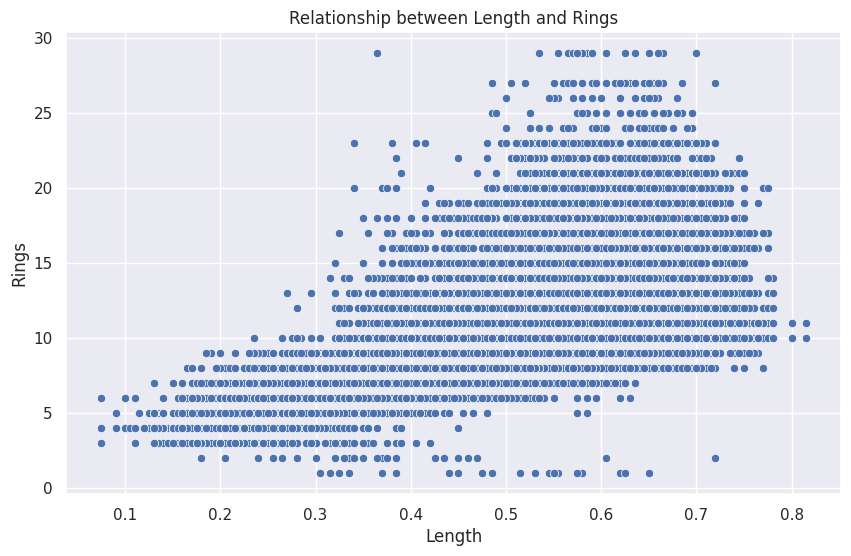

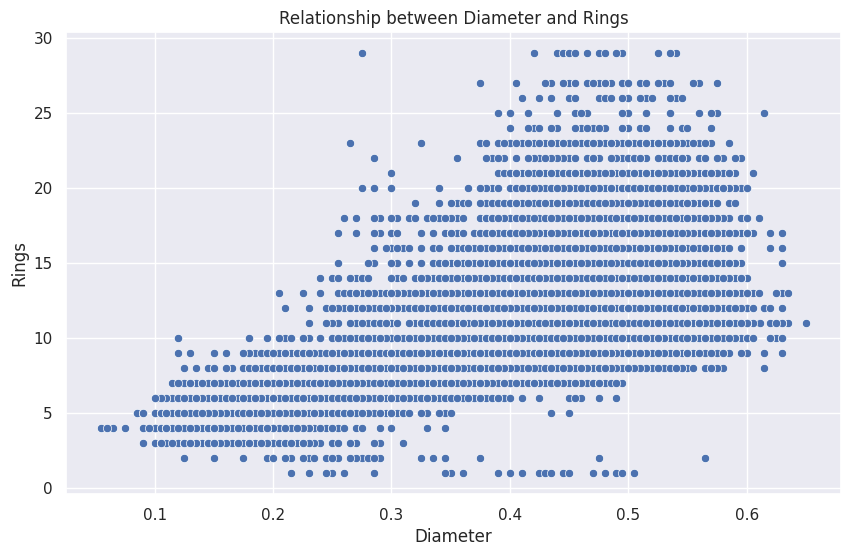

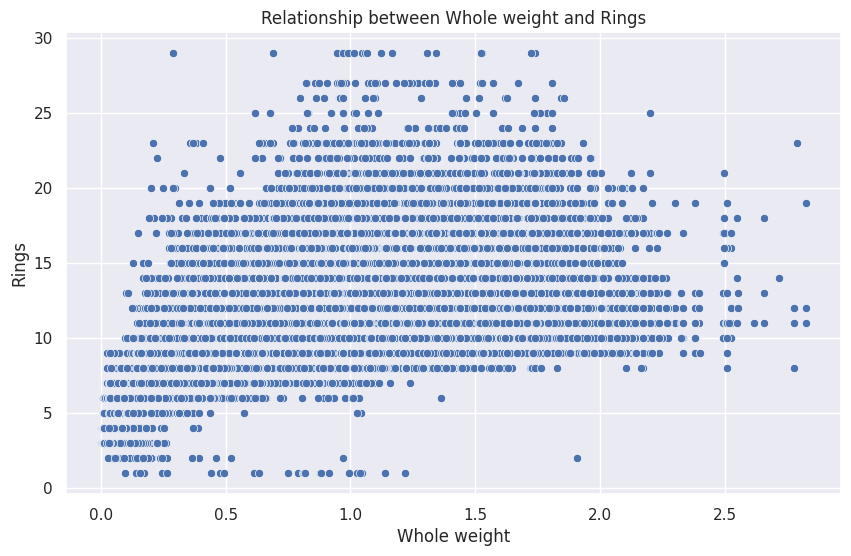

In [11]:
# Exploring relationships between features and the target variable
# Select a few numerical features to plot against Rings
selected_features = ['Length', 'Diameter', 'Whole weight']
for feature in selected_features:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=train_data[feature], y=train_data['Rings'])
    plt.title(f'Relationship between {feature} and Rings')
    plt.xlabel(feature)
    plt.ylabel('Rings')
    plt.show()

The scatter plots show positive relationships between the number of rings and each of the features: length, diameter, and whole weight of the abalone.

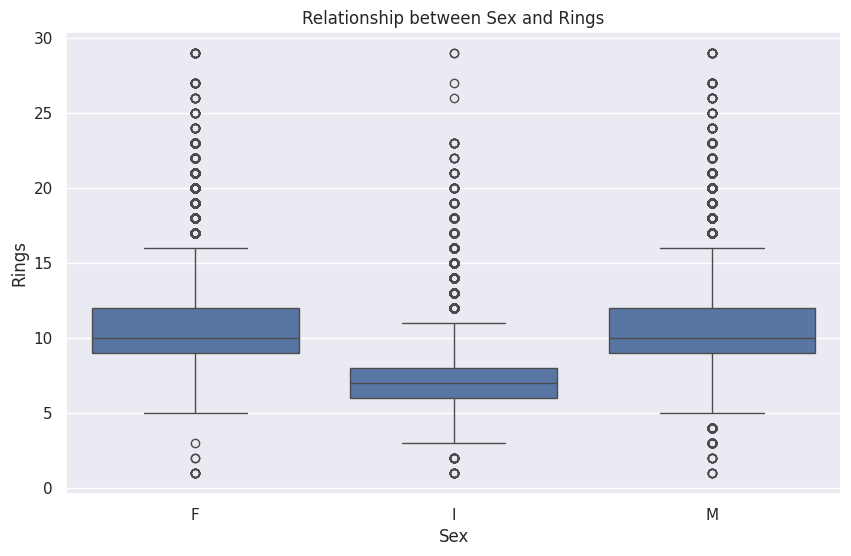

In [13]:

# Relationship between 'Sex' and 'Rings'
plt.figure(figsize=(10, 6))
sns.boxplot(x='Sex', y='Rings', data=train_data)
plt.title('Relationship between Sex and Rings')
plt.xlabel('Sex')
plt.ylabel('Rings')
plt.show()


The box plot shows that female (F) and male (M) abalones tend to have a higher median number of rings compared to infants (I), indicating that adult abalones generally have more rings than juveniles.

Data preprocessing

In [14]:
# Load data
y_train = train_data['Rings']
X_train = train_data.drop(['Rings','id'], axis=1)
# print(X_train.head())
# print(y_train.head())
# print(X_uci.head())
# print(y_uci.head())

new_column_names = X_train.columns.tolist()

# Rename columns in X_uci to match X_train
X_uci.columns = new_column_names
# print(X_uci.head())
# print(y_uci.head())
y_train_series = train_data['Rings']
y_uci_series = y_uci['Rings']
y = pd.concat([y_train_series, y_uci_series], axis=0, ignore_index=True)

X = pd.concat([X_train, X_uci], ignore_index=True)
# y = pd.concat([y_train, y_uci], ignore_index=True)

# print(X.shape[0], y.shape[0])



In [15]:

# Load data
# y = train_data['Rings']
# X = train_data.drop(['Rings'], axis=1)
y = np.log1p(y)
# Identifying categorical and numerical columns
categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]

# Adding Ratio and Polynomial Features
# X['Length_to_Diameter'] = X['Length'] / X['Diameter']
# X['Shucked_to_Whole'] = X['Whole weight.1'] / X['Whole weight']
# X['Viscera_to_Shell'] = X['Whole weight.2'] / X['Shell weight']
# Apply PolynomialFeatures transformation to numerical columns
poly_transformer = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly_transformer.fit_transform(X[numerical_cols])
new_feature_names = [f"poly_{name}" for name in poly_transformer.get_feature_names_out(numerical_cols)]
# # Check sklearn version and use appropriate method to get feature names
# # from sklearn import __version__ as sklearn_version
# # if sklearn_version >= '1.0':
# #     new_feature_names = poly_transformer.get_feature_names_out(numerical_cols)
# # else:
# #     new_feature_names = poly_transformer.get_feature_names(input_features=numerical_cols)

# Convert the polynomial features into a DataFrame
poly_features_df = pd.DataFrame(poly_features, columns=new_feature_names)

# # Concatenate the new polynomial features back to the original feature set
# X = pd.concat([X, poly_features_df], axis=1)

# Concatenate the new polynomial features back to the original feature set
X = pd.concat([X, poly_features_df], axis=1)
# Preprocessors
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
#     ('poly', PolynomialFeatures(degree=2, include_bias=False)),
#     ('scaler', st)
#     ('scaler', RobustScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols ),#, 'Length_to_Diameter','Shucked_to_Whole', 'Viscera_to_Shell']),
        ('cat', categorical_transformer, categorical_cols)
    ])





#Model

In [18]:

# Define the base models
models = {
    # Add model configurations here (configurations as previously detailed)
    'RF': RandomForestRegressor(n_estimators= 927, max_depth= 48,min_samples_split = 11, min_samples_leaf =  5, max_features = 'log2'),
    'HistGBM': HistGradientBoostingRegressor(max_iter= 928, learning_rate= 0.046472370668132215, max_depth= 25, min_samples_leaf= 170, l2_regularization= 0.13019737043879132),
#     'XGBoost': XGBRegressor(max_depth= 9, learning_rate= 0.010109560120408659, n_estimators= 883, subsample= 0.7600504269344156, colsample_bytree= 0.6470454887159172, gamma= 0.8780260068196384, reg_alpha = 0.8173866903859931, reg_lambda = 0.6682377931376331, min_child_weight = 6, max_delta_step = 5, scale_pos_weight= 8.025952590219642, random_state=0),
    'LightGBM': LGBMRegressor(lambda_l1= 6.511336368840992, lambda_l2= 8.515695922558685, num_leaves=107, feature_fraction = 0.6384036510080465, bagging_fraction= 0.9858701262144417, bagging_freq = 3, min_child_samples= 14, learning_rate= 0.032792870093128174, n_estimators = 589, max_depth= 14, subsample= 0.5211049317701997, colsample_bytree= 0.47259763179554076, reg_alpha= 0.1566584211588271, reg_lambda= 0.7818398087829308, random_state=0,  verbosity=-1),
    'CatBoost': CatBoostRegressor(bootstrap_type = 'Bernoulli', depth = 6, learning_rate = 0.06439951642444586, n_estimators = 798, l2_leaf_reg = 5.198054456796824, border_count = 248, grow_policy ='Lossguide', leaf_estimation_iterations = 9, leaf_estimation_method = 'Newton', min_data_in_leaf = 47, subsample = 0.7515338257805598, random_state=0, verbose=False)
}

# Voting Regressor
voting_regressor = VotingRegressor(estimators=[(name, model) for name, model in models.items()])

#Train

In [19]:

# Define RMSLE calculation function
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [20]:
# Setup for cross-validation
n_splits = 5
from sklearn.model_selection import StratifiedKFold
kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
# kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)


# Perform cross-validation
performance = {model_name: [] for model_name in models.keys()}
performance['VotingRegressor'] = []

for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print(f"Fold {fold + 1}")
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', voting_regressor)
    ])
    pipeline.fit(X_train_fold, y_train_fold)
    val_log_preds = pipeline.predict(X_val_fold)
    val_preds = np.expm1(val_log_preds)
    y_val_fold = np.expm1(y_val_fold)
    val_rmsle = rmsle(y_val_fold, val_preds)
    performance['VotingRegressor'].append(val_rmsle)
    print(f"VotingRegressor - Fold {fold + 1} - Validation RMSLE: {val_rmsle}")

Fold 1
VotingRegressor - Fold 1 - Validation RMSLE: 0.1481150879092719
Fold 2
VotingRegressor - Fold 2 - Validation RMSLE: 0.14898681384418355
Fold 3
VotingRegressor - Fold 3 - Validation RMSLE: 0.14999016606250493
Fold 4
VotingRegressor - Fold 4 - Validation RMSLE: 0.14871705063723
Fold 5
VotingRegressor - Fold 5 - Validation RMSLE: 0.14895481209855851


In [21]:

# Calculate average RMSLE across all folds
avg_rmsle = np.mean(performance['VotingRegressor'])
print(f"Average Validation RMSLE for VotingRegressor: {avg_rmsle}")
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', voting_regressor)
])
# Fit the best model on the full dataset
final_pipeline.fit(X, y)

# Save the best model
joblib.dump(final_pipeline, 'final_voting_regressor.joblib')

Average Validation RMSLE for VotingRegressor: 0.1489527861103498


['final_voting_regressor.joblib']

#Test

In [22]:


# test_data['Shucked_to_Whole'] = test_data['Whole weight.1'] / test_data['Whole weight']

# Assuming numerical_cols and poly_transformer are defined and fitted from your training session
# Assume `numerical_cols` and `poly_transformer` are already defined and `poly_transformer` is fitted from your training session
test_poly_features = poly_transformer.transform(test_data[numerical_cols])

# Generate new column names by adding 'poly_' prefix to each polynomial feature name
# Here, poly_transformer.get_feature_names_out() should provide the feature names directly since the transformer has been already fitted on the training data
new_feature_names = ["poly_" + name for name in poly_transformer.get_feature_names_out()]

# Create a DataFrame for the polynomial features with new column names
test_poly_features_df = pd.DataFrame(test_poly_features, columns=new_feature_names, index=test_data.index)

# Concatenate the new polynomial features back to the original test feature set
test_data_enhanced = pd.concat([test_data, test_poly_features_df], axis=1)

# Optionally: Predict and save submission for test data if needed
test_preds_log = final_pipeline.predict(test_data_enhanced)
test_preds = np.expm1(test_preds_log)
print(test_preds)
submission = pd.DataFrame({'id': test_data['id'], 'Rings': test_preds})
submission.to_csv('submission.csv', index=False)
print("Submission saved to 'submission.csv'.")


[ 9.73632533  9.7000925   9.89474988 ... 11.77039705 13.4900341
  8.29285742]
Submission saved to 'submission.csv'.


#Hyperparameter tuning

In [ ]:
# #Example code:
# # Define the objective function for Optuna
# def objective(trial):
#     # Suggest hyperparameters
#     n_estimators = trial.suggest_int('n_estimators', 100, 1000)
#     max_depth = trial.suggest_int('max_depth', 10, 50)
#     min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
#     min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
#     max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])

#     # Create the model with suggested hyperparameters
#     model = RandomForestRegressor(
#         n_estimators=n_estimators,
#         max_depth=max_depth,
#         min_samples_split=min_samples_split,
#         min_samples_leaf=min_samples_leaf,
#         max_features=max_features,
#         random_state=42
#     )

#     # Perform K-Fold cross-validation
#     kf = KFold(n_splits=5, shuffle=True, random_state=42)
#     scores = cross_val_score(model, X, y, scoring='neg_mean_squared_log_error', cv=kf)

#     # Return the mean score (Optuna minimizes, so we return the negative mean)
#     return -scores.mean()

# # Create an Optuna study and optimize the objective function
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50)

# # Print the best hyperparameters
# print('Best hyperparameters: ', study.best_params)

#Notes
1. **Data Preprocessing**:
Effective preprocessing steps were employed, including the imputation of missing values and one-hot encoding for categorical variables. Numerical features were enhanced using polynomial transformations to capture non-linear relationships, ensuring that the models have a comprehensive and clean dataset to learn from.
2. **Feature Engineering**:
Additional features were created to improve model performance, such as ratio features (e.g., 'Shucked_to_Whole') and polynomial features. These derived features help models capture more complex patterns and interactions within the data, potentially leading to more accurate predictions.
3. **Model Selection and Training**:
A diverse set of regression models, including tree-based, boosting, and ensemble methods, were selected to capture various aspects of the data. Each model's hyperparameters were fine-tuned using Optuna, an efficient hyperparameter optimization framework, to ensure optimal performance.
4. **Cross-Validation**:
A robust K-Fold cross-validation strategy was implemented to evaluate model performance consistently. This approach helps in understanding how the model generalizes to unseen data and mitigates the risk of overfitting by providing multiple performance metrics across different subsets of the data.
5. **Ensemble Learning**:
The Voting Regressor was used to aggregate the predictions of the individual models, leveraging the strengths of each to improve overall prediction accuracy. This ensemble method reduces the risk of poor performance due to any single model's limitations, leading to more stable and reliable predictions.
6. **Performance Evaluation**:
The Root Mean Squared Logarithmic Error (RMSLE) metric was used to evaluate model performance, as it is sensitive to both the magnitude of errors and the scale of predictions. This choice ensures that the model not only minimizes large errors but also maintains accuracy across different scales of the target variable.
7. **Model Persistence**:
The final model pipeline, including preprocessing steps and the trained ensemble model, was saved using joblib. This allows for easy deployment and reuse, ensuring that the model can be efficiently applied to new data without the need for retraining from scratch.



# FAQs

1. *What is the Abalone Dataset?* <br>
The Abalone dataset contains physical measurements of abalones, a type of marine mollusk, and the number of rings in their shell, which indicates their age. It is often used for regression and classification tasks in machine learning.

2. *How is the Age of an Abalone Determined?*<br>
The age of an abalone is determined by counting the number of rings in its shell. Each ring typically represents one year of growth, similar to the way tree rings indicate a tree's age.

3. *What Features are Included in the Abalone Dataset?*<br>
The dataset includes features such as sex, length, diameter, height, whole weight, shucked weight, viscera weight, shell weight, and the number of rings.

4. *Why Use Regression Instead of Classification for the Abalone Dataset?*<br>
While classification can categorize abalones into age groups, regression is more suitable for predicting continuous values, such as the exact number of rings (age). This provides more precise age estimation.

5. *What Are Some Common Challenges with the Abalone Dataset?*<br>
Some common challenges include dealing with imbalanced data (more instances of certain ages), handling outliers, and ensuring that the model generalizes well to new data.

6. *How Can Feature Engineering Improve Model Performance on the Abalone Dataset?*<br>
Feature engineering can create new features from existing ones, such as ratios or polynomial transformations, that capture more complex relationships in the data. This can improve the model's ability to predict abalone age accurately.

7. *What Evaluation Metrics Are Suitable for the Abalone Dataset?*<br>
For regression tasks, metrics like Root Mean Squared Error (RMSE) or Root Mean Squared Logarithmic Error (RMSLE) are suitable. For classification tasks, accuracy, precision, recall, and F1-score can be used.

8. *How Can Cross-Validation Help in Model Training?*<br>
Cross-validation, such as K-Fold cross-validation, helps in assessing the model's performance on different subsets of the data, ensuring that the model generalizes well and is not overfitting.

9. *Why Is Hyperparameter Optimization Important?*<br>
Hyperparameter optimization, such as using Optuna, helps in finding the best set of parameters for the model. This can significantly improve the model's performance by fine-tuning it to the specific characteristics of the dataset.